## Advanced Model

In [2]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
engine = create_engine("postgresql:///kc_housing")
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
import seaborn as sns

In [190]:
def pullsqldata():
    """This function pulls the necessary columns and rows from the PostGRES DB into a Pandas Dataframe in order 
    to continue with our EDA """
    
    engine = create_engine("postgresql:///kc_housing")
    query = """
                SELECT *
                FROM rpsale AS s
                INNER JOIN resbldg AS b ON CONCAT(s.Major,s.Minor) = CONCAT(b.Major, b.Minor)
                INNER JOIN parcel AS p ON CONCAT(s.Major,s.Minor) = CONCAT(p.Major,p.Minor)
                WHERE EXTRACT(YEAR FROM CAST(documentdate AS DATE)) = 2018
                    AND p.proptype = 'R'
                ;"""
    kc_df = pd.read_sql(sql = query, con = engine)
    return kc_df

def clean_data_intial(df):
    """ This function cleans the housing data by removing outliers, sale price == 0, and irrelevant columns. 
    """
    #We chose a minimum sale vale of 10000 and a maximium sale value of 2 sigma
    df_clean = df[(df['saleprice']>100000) & (df['saleprice'] <  (2*df['saleprice'].std())+df['saleprice'].mean())]
    #These are irrelevant or highly covariant columns
    columns_to_drop = ['documentdate',
                       'excisetaxnbr',
                       'recordingnbr',
                       'volume',
                       'page',
                       'platnbr',
                       'plattype',
                       'platlot',
                       'platblock',
                        'sellername',
                        'buyername',
                        'streetname',
                        'streettype',
                        'directionsuffix',
                        'buildingnumber',
                        'major',
                        'minor',
                        'bldggradevar',
                        'sqfthalffloor',
                        'sqft2ndfloor',
                        'sqftupperfloor',
                        'sqftunfinfull',
                        'sqftunfinhalf',
                        'sqfttotbasement',
                        'sqftfinbasement',
                        'brickstone',
                        'viewutilization',
                        'propname',
                        'platname',
                        'platlot',
                        'platblock',
                        'range',
                        'township',
                        'section',
                        'quartersection',
                        'area',
                        'subarea',
                        'specarea',
                        'specsubarea',
                        'levycode',
                        'districtname',
                        'currentzoning',
                        'topography',
                        'currentusedesignation',
                        'salewarning',
                        'wetland',
                        'stream',
                        'seismichazard',
                        'landslidehazard',
                        'address',
                        'airportnoise',
                        'contamination',
                        'dnrlease',
                         'coalminehazard',
                         'criticaldrainage',
                         'erosionhazard',
                         'landfillbuffer',
                         'hundredyrfloodplain',
                         'steepslopehazard',
                         'speciesofconcern',
                         'sensitiveareatract',
                         'daylightbasement',
                         'fraction',
                        'directionprefix', 'proptype','unbuildable', 'bldgnbr']
    df_clean.drop(columns=columns_to_drop, inplace = True)
    #The columns with Y or N need to be 1 or 0 to model
    df_clean['othernuisances'] = [i.strip() for i in df_clean['othernuisances']]
    df_clean.replace(('Y', 'N'), (1, 0), inplace=True)
    
    #To model the houses that take up more space of thier plot (smaller yard) we need a ratio feature
    #We assume an acturate metric of the house's footprint is the first floor plus any attached garage. This 
    #unfortunatley may not account for detached garages
    df_clean['footprint_ratio']=(df_clean['sqft1stfloor']+df_clean['sqftgarageattached'])/df_clean['sqftlot']
#     df_clean.drop(columns = 'sqft1stfloor', inplace = True)

    return df_clean

def find_highest_correlation(df, dep ='saleprice'):
    try:
        X = df.drop([dep], axis = 1)
    except:
        X = df
    Y = df[dep]
    
    num = 0
    for element in X.columns:
        a = pearsonr(list(X[element]),list(Y))
        if np.abs(a[0]) > num:
            num = a[0]
    for element in X.columns:
        a = pearsonr(list(X[element]),list(Y))
        if np.abs(a[0]) == num:
            return element

In [191]:
df = pullsqldata()
df_clean = clean_data_intial(df)

/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/pandas/core/frame.py:4278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/

In [192]:
# drops triplexes from the dataframe
triplex = df_clean.loc[df_clean['nbrlivingunits'] >= 3]
df_clean.drop(triplex.index, inplace= True, axis=0) 
# create a duplex column, value of 1 is duplex, 0 is
df_clean['duplex'] = df_clean['nbrlivingunits'] - 1       

/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [193]:
df_clean['duplex'].value_counts()

0.0    28083
1.0      350
Name: duplex, dtype: int64

In [194]:
df_clean.shape

(28433, 86)

In [195]:
df['othernuisances'] = [x.strip() for x in df['othernuisances']]
df.replace(('Y', 'N'), (1, 0), inplace=True)
df_clean.shape

(28433, 86)

### Base Model

In [196]:
base_model = df_clean[['saleprice','sqfttotliving', 'sqftlot', 'footprint_ratio', 'duplex']]


In [197]:
Ybase = base_model['saleprice']
Xbase = base_model.drop(['saleprice'], axis=1)

In [198]:
Xbase_int = sm.add_constant(Xbase)
model_base = sm.OLS(Ybase, Xbase_int).fit()
model_base.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     3225.
Date:                Thu, 05 Dec 2019   Prob (F-statistic):               0.00
Time:                        17:55:09   Log-Likelihood:            -3.9905e+05
No. Observations:               28433   AIC:                         7.981e+05
Df Residuals:                   28428   BIC:                         7.982e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1.939e+05   5471.504     35.431      0.000    1.83e+05    2.05e+05
sqfttotliving     219.6850      2.018    108.841      0.000     215.729     223.641
sqftlot             0.2067      0.034      6.114      0.000       0.140       0.273
footprint_ratio  2.795e+05   1.49e+04     18.791      0.000     2.5e+05    3.09e+05
duplex           6.552e+04   1.62e+04      4.042      0.000    3.37e+04    9.73e+04
==============================================================================
Omnibus:                     3616.299   Durbin-Watson:                   0.871
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9327.097
Skew:                           0.722   Prob(JB):                         0.00
Kurtosis:                       5.406   Cond. No.                     5.31e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.31e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### determining the correlation between 'independent' functions

In [199]:
correlation_cut_off = .5

df_X = df_clean.drop(['saleprice'], axis = 1)



corr = df_X.corr() > correlation_cut_off


corr_list = []
for col in corr.columns:
    corr_v = corr[col][corr[col] == True].index.tolist()
    if len(corr_v) > 1:
        corr_list.append((col, corr_v))
    
corr_list
# for col in corr.columns:
#     if corr[col].sum() > 1:

#         corr_list.append(col)

[('nbrlivingunits', ['nbrlivingunits', 'duplex']),
 ('bldggrade', ['bldggrade', 'sqfttotliving', 'yrbuilt']),
 ('sqft1stfloor', ['sqft1stfloor', 'sqfttotliving']),
 ('sqfttotliving',
  ['bldggrade', 'sqft1stfloor', 'sqfttotliving', 'bedrooms', 'bathfullcount']),
 ('bedrooms', ['sqfttotliving', 'bedrooms']),
 ('bathfullcount', ['sqfttotliving', 'bathfullcount']),
 ('fpmultistory', ['fpmultistory', 'fpadditional']),
 ('fpadditional', ['fpmultistory', 'fpadditional']),
 ('yrbuilt', ['bldggrade', 'yrbuilt']),
 ('olympics', ['olympics', 'pugetsound']),
 ('territorial', ['territorial', 'pugetsound']),
 ('pugetsound', ['olympics', 'territorial', 'pugetsound']),
 ('smalllakerivercreek', ['smalllakerivercreek', 'wfntlocation']),
 ('wfntlocation',
  ['smalllakerivercreek', 'wfntlocation', 'wfntfootage', 'wfntbank']),
 ('wfntfootage', ['wfntlocation', 'wfntfootage', 'wfntbank']),
 ('wfntbank',
  ['wfntlocation',
   'wfntfootage',
   'wfntbank',
   'wfntrestrictedaccess',
   'tidelandshoreland']),

In [200]:
df_zip = df_clean[df_clean['zipcode'].str.contains ('98')]
num = '98075-8010'
df_zip['zipcode'] = df_clean['zipcode'].map(lambda x: x[0:5])


/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [201]:
df_zip.zipcode.value_counts()

98042    797
98023    712
98038    681
98058    636
98115    587
        ... 
98068      5
98000      2
98009      1
98422      1
98134      1
Name: zipcode, Length: 82, dtype: int64

In [202]:
df_zip_test = df_zip[['saleprice','zipcode']]


df_zip['zipcode'] = pd.Categorical(df_zip['zipcode'])
df_zip_test = pd.get_dummies(df_zip['zipcode'], prefix = 'zip')



/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [203]:
df_test = df_zip[['saleprice']]
df_test.join(df_zip_test, how = 'left')

Xzip = df_zip_test.iloc[:,1:]
Xzip

,zip_98001,zip_98002,zip_98003,zip_98004,zip_98005,zip_98006,zip_98007,zip_98008,zip_98009,zip_98010,...,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199,zip_98224,zip_98288,zip_98354,zip_98422
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43732,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43735,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43736,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43737,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [204]:
X_int = sm.add_constant(Xzip)
model = sm.OLS(df_zip[['saleprice']], X_int).fit()
model.summary()

/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(ax

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                     299.3
Date:                Thu, 05 Dec 2019   Prob (F-statistic):               0.00
Time:                        17:55:15   Log-Likelihood:            -3.2292e+05
No. Observations:               23335   AIC:                         6.460e+05
Df Residuals:                   23253   BIC:                         6.467e+05
Df Model:                          81                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.245e+06   1.75e+05      7.102      0.000    9.02e+05    1.59e+06
zip_98001  -8.616e+05   1.76e+05     -4.904      0.000   -1.21e+06   -5.17e+05
zip_98002  -9.334e+05   1.76e+05     -5.309      0.000   -1.28e+06   -5.89e+05
zip_98003  -8.502e+05   1.76e+05     -4.837      0.000   -1.19e+06   -5.06e+05
zip_98004   1.622e+05   1.77e+05      0.918      0.359   -1.84e+05    5.09e+05
zip_98005  -1.911e+04   1.77e+05     -0.108      0.914   -3.65e+05    3.27e+05
zip_98006  -1.574e+05   1.76e+05     -0.896      0.371   -5.02e+05    1.87e+05
zip_98007  -3.554e+05   1.77e+05     -2.011      0.044   -7.02e+05   -8950.077
zip_98008  -3.547e+05   1.76e+05     -2.016      0.044   -6.99e+05   -9857.168
zip_98009  -5.953e+05   3.04e+05     -1.960      0.050   -1.19e+06      31.261
zip_98010   -7.41e+05   1.77e+05     -4.188      0.000   -1.09e+06   -3.94e+05
zip_98011  -5.542e+05   1.76e+05     -3.145      0.002      -9e+05   -2.09e+05
zip_98014  -5.519e+05   1.77e+05     -3.124      0.002   -8.98e+05   -2.06e+05
zip_98019  -6.135e+05   1.76e+05     -3.481      0.001   -9.59e+05   -2.68e+05
zip_98022  -8.374e+05   1.76e+05     -4.763      0.000   -1.18e+06   -4.93e+05
zip_98023  -8.447e+05   1.76e+05     -4.810      0.000   -1.19e+06      -5e+05
zip_98024  -4.845e+05   1.78e+05     -2.729      0.006   -8.32e+05   -1.37e+05
zip_98027  -3.767e+05   1.76e+05     -2.142      0.032   -7.21e+05    -3.2e+04
zip_98028  -5.835e+05   1.76e+05     -3.315      0.001   -9.29e+05   -2.39e+05
zip_98029  -3.336e+05   1.76e+05     -1.895      0.058   -6.79e+05    1.15e+04
zip_98030   -8.46e+05   1.76e+05     -4.809      0.000   -1.19e+06   -5.01e+05
zip_98031  -8.157e+05   1.76e+05     -4.639      0.000   -1.16e+06   -4.71e+05
zip_98032  -8.789e+05   1.76e+05     -4.990      0.000   -1.22e+06   -5.34e+05
zip_98033  -9.206e+04   1.76e+05     -0.524      0.600   -4.37e+05    2.52e+05
zip_98034  -4.784e+05   1.76e+05     -2.724      0.006   -8.23e+05   -1.34e+05
zip_98038  -7.126e+05   1.76e+05     -4.058      0.000   -1.06e+06   -3.68e+05
zip_98039   2.959e+05   1.87e+05      1.585      0.113      -7e+04    6.62e+05
zip_98040   1.337e+05   1.76e+05      0.759      0.448   -2.12e+05    4.79e+05
zip_98042  -8.141e+05   1.76e+05     -4.637      0.000   -1.16e+06    -4.7e+05
zip_98045  -5.866e+05   1.76e+05     -3.336      0.001   -9.31e+05   -2.42e+05
zip_98047  -9.485e+05   1.78e+05     -5.316      0.000    -1.3e+06   -5.99e+05
zip_98050  -4.512e+05   1.99e+05     -2.269      0.023   -8.41e+05   -6.15e+04
zip_98051  -6.737e+05    1.8e+05     -3.751      0.000   -1.03e+06   -3.22e+05
zip_98052  -3.195e+05   1.76e+05     -1.818      0.069   -6.64e+05    2.49e+04
zip_98053  -3.137e+05   1.76e+05     -1.783      0.075   -6.59e+05    3.11e+04
zip_98055   -8.08e+05   1.76e+05     -4.593      0.000   -1.15e+06   -4.63e+05
zi

In [205]:
av_model1 = Xzip.join(base_model, how = 'left')

In [206]:
x_1 = av_model1.drop(['saleprice'], axis = 1)

X_int = sm.add_constant(x_1)
model = sm.OLS(av_model1[['saleprice']], X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     636.0
Date:                Thu, 05 Dec 2019   Prob (F-statistic):               0.00
Time:                        17:55:23   Log-Likelihood:            -3.1723e+05
No. Observations:               23335   AIC:                         6.346e+05
Df Residuals:                   23249   BIC:                         6.353e+05
Df Model:                          85                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            3.335e+05   1.38e+05      2.414      0.016    6.27e+04    6.04e+05
zip_98001       -3.109e+05   1.38e+05     -2.248      0.025   -5.82e+05   -3.98e+04
zip_98002         -2.9e+05   1.38e+05     -2.096      0.036   -5.61e+05   -1.88e+04
zip_98003       -2.833e+05   1.38e+05     -2.048      0.041   -5.54e+05   -1.22e+04
zip_98004        6.085e+05   1.39e+05      4.376      0.000    3.36e+05    8.81e+05
zip_98005        3.772e+05   1.39e+05      2.714      0.007    1.05e+05     6.5e+05
zip_98006         2.63e+05   1.38e+05      1.902      0.057   -8017.838    5.34e+05
zip_98007        1.726e+05   1.39e+05      1.241      0.215      -1e+05    4.45e+05
zip_98008        1.681e+05   1.38e+05      1.214      0.225   -1.03e+05    4.39e+05
zip_98009        -2.72e+05   2.38e+05     -1.141      0.254   -7.39e+05    1.95e+05
zip_98010       -1.965e+05   1.39e+05     -1.412      0.158   -4.69e+05    7.63e+04
zip_98011       -3.763e+04   1.39e+05     -0.271      0.786   -3.09e+05    2.34e+05
zip_98014       -1.227e+05   1.39e+05     -0.884      0.377   -3.95e+05    1.49e+05
zip_98019        -1.45e+05   1.39e+05     -1.046      0.295   -4.17e+05    1.27e+05
zip_98022       -2.827e+05   1.38e+05     -2.045      0.041   -5.54e+05   -1.18e+04
zip_98023       -3.023e+05   1.38e+05     -2.188      0.029   -5.73e+05   -3.14e+04
zip_98024        -8.76e+04   1.39e+05     -0.628      0.530   -3.61e+05    1.86e+05
zip_98027        3.234e+04   1.38e+05      0.234      0.815   -2.39e+05    3.03e+05
zip_98028       -6.268e+04   1.39e+05     -0.453      0.651   -3.34e+05    2.09e+05
zip_98029        1.416e+05   1.39e+05      1.022      0.307    -1.3e+05    4.13e+05
zip_98030       -2.713e+05   1.38e+05     -1.960      0.050   -5.43e+05      60.351
zip_98031       -2.653e+05   1.38e+05     -1.917      0.055   -5.36e+05    5968.634
zip_98032       -2.839e+05   1.39e+05     -2.048      0.041   -5.56e+05   -1.22e+04
zip_98033        3.983e+05   1.38e+05      2.879      0.004    1.27e+05     6.7e+05
zip_98034        6.157e+04   1.38e+05      0.445      0.656   -2.09e+05    3.33e+05
zip_98038       -2.199e+05   1.38e+05     -1.591      0.112   -4.91e+05    5.09e+04
zip_98039        8.363e+05   1.47e+05      5.695      0.000    5.48e+05    1.12e+06
zip_98040        5.311e+05   1.39e+05      3.831      0.000    2.59e+05    8.03e+05
zip_98042       -2.677e+05   1.38e+05     -1.938      0.053   -5.38e+05    3075.494
zip_98045       -6.434e+04   1.38e+05     -0.465      0.642   -3.35e+05    2.07e+05
zip_98047       -3.063e+05    1.4e+05     -2.182      0.029   -5.81e+05   -3.11e+04
zip_98050       -6.183e+04   1.56e+05     -0.396      0.692   -3.68e+05    2.44e+05
zip_98051       -2.604e+05   1.41e+05     -1.845      0.065   -5.37e+05    1.62e+04
zip_98052        1.826e+05   1.38e+05      1.320      0.187

### checking to see if footprint ratio is better predictor than lotsize and footprint

In [207]:
# r^2 is 9
new_base_model = df_clean[['saleprice','sqfttotliving', 'sqftlot', 'sqft1stfloor', 'duplex']]

av_model2 = Xzip.join(new_base_model, how = 'left')

In [208]:
x_2 = av_model2.drop(['saleprice'], axis = 1)

X_int = sm.add_constant(x_2)
avmodel2 = sm.OLS(av_model2[['saleprice']], X_int).fit()
avmodel2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     633.0
Date:                Thu, 05 Dec 2019   Prob (F-statistic):               0.00
Time:                        17:55:27   Log-Likelihood:            -3.1727e+05
No. Observations:               23335   AIC:                         6.347e+05
Df Residuals:                   23249   BIC:                         6.354e+05
Df Model:                          85                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          3.067e+05   1.38e+05      2.215      0.027    3.53e+04    5.78e+05
zip_98001     -3.004e+05   1.39e+05     -2.168      0.030   -5.72e+05   -2.89e+04
zip_98002     -2.823e+05   1.39e+05     -2.036      0.042   -5.54e+05   -1.06e+04
zip_98003     -2.746e+05   1.39e+05     -1.981      0.048   -5.46e+05   -2966.968
zip_98004      6.206e+05   1.39e+05      4.455      0.000    3.48e+05    8.94e+05
zip_98005      3.908e+05   1.39e+05      2.807      0.005    1.18e+05    6.64e+05
zip_98006      2.733e+05   1.39e+05      1.973      0.049    1724.157    5.45e+05
zip_98007      1.805e+05   1.39e+05      1.295      0.195   -9.26e+04    4.54e+05
zip_98008      1.762e+05   1.39e+05      1.270      0.204   -9.56e+04    4.48e+05
zip_98009     -2.835e+05   2.39e+05     -1.187      0.235   -7.52e+05    1.85e+05
zip_98010     -1.842e+05   1.39e+05     -1.321      0.186   -4.58e+05    8.91e+04
zip_98011     -2.795e+04   1.39e+05     -0.201      0.841      -3e+05    2.44e+05
zip_98014     -1.107e+05   1.39e+05     -0.796      0.426   -3.83e+05    1.62e+05
zip_98019     -1.331e+05   1.39e+05     -0.959      0.337   -4.05e+05    1.39e+05
zip_98022       -2.7e+05   1.38e+05     -1.950      0.051   -5.41e+05    1377.591
zip_98023     -2.932e+05   1.38e+05     -2.118      0.034   -5.65e+05   -2.19e+04
zip_98024     -7.195e+04    1.4e+05     -0.515      0.606   -3.46e+05    2.02e+05
zip_98027      4.715e+04   1.39e+05      0.340      0.734   -2.24e+05    3.19e+05
zip_98028     -5.291e+04   1.39e+05     -0.381      0.703   -3.25e+05    2.19e+05
zip_98029      1.389e+05   1.39e+05      1.001      0.317   -1.33e+05    4.11e+05
zip_98030     -2.634e+05   1.39e+05     -1.899      0.058   -5.35e+05    8502.445
zip_98031     -2.564e+05   1.39e+05     -1.849      0.064   -5.28e+05    1.54e+04
zip_98032     -2.735e+05   1.39e+05     -1.969      0.049   -5.46e+05   -1274.342
zip_98033      4.067e+05   1.39e+05      2.935      0.003    1.35e+05    6.78e+05
zip_98034      6.828e+04   1.39e+05      0.493      0.622   -2.03e+05     3.4e+05
zip_98038     -2.135e+05   1.38e+05     -1.542      0.123   -4.85e+05    5.78e+04
zip_98039      8.497e+05   1.47e+05      5.777      0.000    5.61e+05    1.14e+06
zip_98040       5.43e+05   1.39e+05      3.911      0.000    2.71e+05    8.15e+05
zip_98042     -2.602e+05   1.38e+05     -1.880      0.060   -5.31e+05    1.11e+04
zip_98045     -5.437e+04   1.39e+05     -0.392      0.695   -3.26e+05    2.17e+05
zip_98047     -2.937e+05   1.41e+05     -2.088      0.037   -5.69e+05   -1.81e+04
zip_98050     -4.513e+04   1.56e+05     -0.289      0.773   -3.52e+05    2.61e+05
zip_98051     -2.389e+05   1.41e+05     -1.690      0.091   -5.16e+05    3.81e+04
zip_98052      1.901e+05   1.39e+05      1.372      0.170   -8.14e+04    4.62e+05
zip_98053      1.316e+05   1.39e+05      0.949   

no noticable effect when switching the footprint lot ratio with the footprint and the lot individually. Will probably drop all in future test

### determine list of best correlating data

In [209]:
df_clean['bldggrade'] = df_clean['bldggrade'].astype(int) 
df_b = df_clean[['saleprice']]

df['bldggrade'] = pd.Categorical(df['bldggrade'])
df_bldg = pd.get_dummies(df['bldggrade'], prefix = 'bldg')
df_bldg

/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,bldg_1.0,bldg_2.0,bldg_3.0,bldg_4.0,bldg_5.0,bldg_6.0,bldg_7.0,bldg_8.0,bldg_9.0,bldg_10.0,bldg_11.0,bldg_12.0,bldg_13.0,bldg_20.0
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43736,0,0,0,0,1,0,0,0,0,0,0,0,0,0
43737,0,0,0,0,0,0,0,0,1,0,0,0,0,0
43738,0,0,0,0,0,0,0,0,1,0,0,0,0,0
43739,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [210]:
av_model3 = av_model1.copy()
av_model3 = av_model3.join(df_bldg.iloc[:,4:], how = 'left')


In [211]:
x_3 = av_model3.drop(['saleprice'], axis = 1)

X_int = sm.add_constant(x_3)
avmodel3 = sm.OLS(av_model3[['saleprice']], X_int).fit()
avmodel3.summary()

/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     679.0
Date:                Thu, 05 Dec 2019   Prob (F-statistic):               0.00
Time:                        17:55:35   Log-Likelihood:            -3.1584e+05
No. Observations:               23335   AIC:                         6.319e+05
Df Residuals:                   23240   BIC:                         6.326e+05
Df Model:                          94                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            4.453e+05   1.33e+05      3.340      0.001    1.84e+05    7.07e+05
zip_98001       -2.222e+05    1.3e+05     -1.705      0.088   -4.78e+05    3.33e+04
zip_98002       -2.047e+05    1.3e+05     -1.569      0.117    -4.6e+05     5.1e+04
zip_98003       -2.136e+05    1.3e+05     -1.638      0.101   -4.69e+05     4.2e+04
zip_98004        6.659e+05   1.31e+05      5.081      0.000    4.09e+05    9.23e+05
zip_98005        3.941e+05   1.31e+05      3.009      0.003    1.37e+05    6.51e+05
zip_98006        2.712e+05    1.3e+05      2.081      0.037    1.58e+04    5.27e+05
zip_98007        2.184e+05   1.31e+05      1.666      0.096   -3.86e+04    4.75e+05
zip_98008        2.354e+05    1.3e+05      1.804      0.071   -2.04e+04    4.91e+05
zip_98009       -2.758e+05   2.25e+05     -1.227      0.220   -7.16e+05    1.65e+05
zip_98010       -1.375e+05   1.31e+05     -1.048      0.294   -3.95e+05     1.2e+05
zip_98011        2.263e+04   1.31e+05      0.173      0.863   -2.34e+05    2.79e+05
zip_98014       -4.514e+04   1.31e+05     -0.345      0.730   -3.02e+05    2.11e+05
zip_98019       -7.427e+04   1.31e+05     -0.569      0.570    -3.3e+05    1.82e+05
zip_98022           -2e+05    1.3e+05     -1.535      0.125   -4.55e+05    5.54e+04
zip_98023       -2.408e+05    1.3e+05     -1.849      0.064   -4.96e+05    1.45e+04
zip_98024       -1.965e+04   1.31e+05     -0.150      0.881   -2.77e+05    2.38e+05
zip_98027          7.4e+04    1.3e+05      0.568      0.570   -1.82e+05     3.3e+05
zip_98028        1.503e+04   1.31e+05      0.115      0.908   -2.41e+05    2.71e+05
zip_98029        1.472e+05   1.31e+05      1.127      0.260   -1.09e+05    4.03e+05
zip_98030       -1.844e+05    1.3e+05     -1.413      0.158    -4.4e+05    7.14e+04
zip_98031       -1.835e+05    1.3e+05     -1.407      0.159   -4.39e+05    7.21e+04
zip_98032       -2.029e+05   1.31e+05     -1.553      0.120   -4.59e+05    5.32e+04
zip_98033        4.407e+05    1.3e+05      3.380      0.001    1.85e+05    6.96e+05
zip_98034        1.372e+05    1.3e+05      1.053      0.292   -1.18e+05    3.93e+05
zip_98038       -1.491e+05    1.3e+05     -1.145      0.252   -4.04e+05    1.06e+05
zip_98039        8.607e+05   1.38e+05      6.219      0.000    5.89e+05    1.13e+06
zip_98040        5.331e+05   1.31e+05      4.081      0.000    2.77e+05    7.89e+05
zip_98042        -1.94e+05    1.3e+05     -1.490      0.136   -4.49e+05    6.12e+04
zip_98045       -3029.8187    1.3e+05     -0.023      0.981   -2.59e+05    2.53e+05
zip_98047       -2.169e+05   1.32e+05     -1.639      0.101   -4.76e+05    4.25e+04
zip_98050       -5.071e+04   1.47e+05     -0.345      0.730   -3.39e+05    2.38e+05
zip_98051       -1.938e+05   1.33e+05     -1.457      0.145   -4.54e+05    6.69e+04
zip_98052        2.283e+05    1.3e+05      1.752      0.080

### check zipcode for normal distribution

In [212]:
df_sale = df_clean['saleprice']

In [213]:
zip_res = Xzip.join(df_sale, how = 'left')




lookup_dictzip = {}
for col in zip_res.columns:
    try:
        index = int(col[-3:])
        search_string = col[-3:]
        amount = int(zip_res[zip_res[col]== True]['saleprice'].mean())
        span = float(zip_res[zip_res[col]== True]['saleprice'].std())
        lookup_dictzip[col] = (amount, span)
    except:
        continue
        


error_list = []       
for col in zip_res.columns:
    try:
        df_filtered = zip_res[zip_res[col]== True]
        amount = df_filtered['saleprice'].mean()
        span = float(df_filtered['saleprice'].std())
        df_filtered['sigma_difference'] = (df_filtered['saleprice'] - amount)/span
        a = list(df_filtered['sigma_difference'])
        error_list.extend(a)

        
    except:
        continue       

        

/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


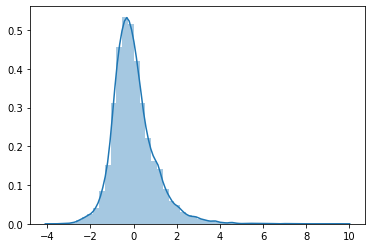

In [214]:
info = list(filter(lambda x: np.abs(x)> 0, error_list))
sns.distplot(info)

already deleted


<ErrorbarContainer object of 3 artists>

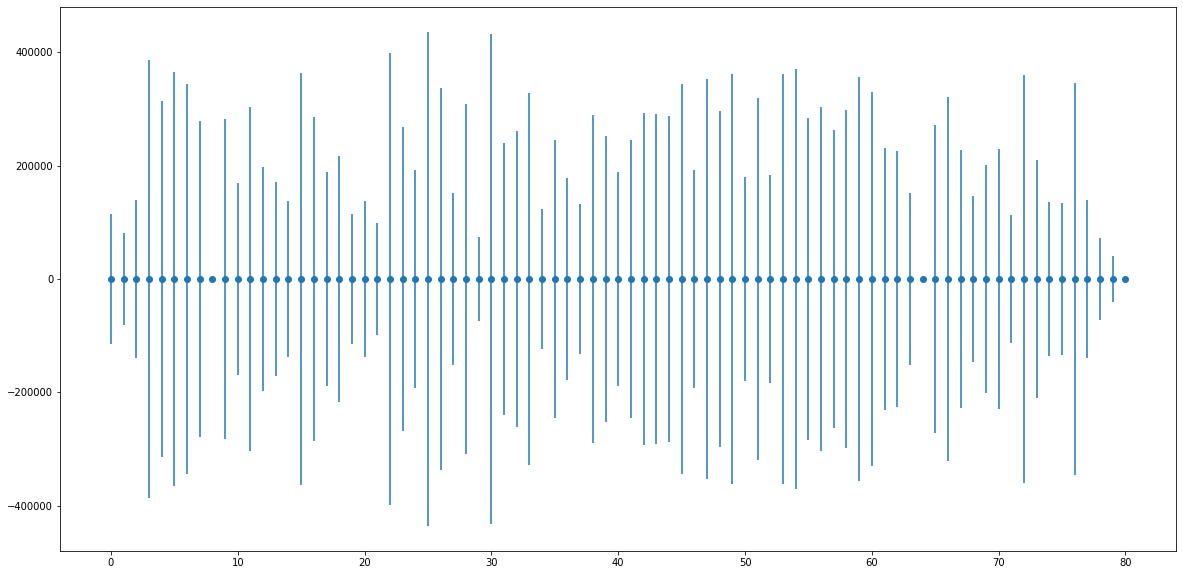

In [215]:
try:
    del lookup_dictzip[zip_98009]
    del lookup_dictzip[zip_98422]
    del lookup_dictzip[zip_98134]
    print('all deleted')
except:
    print('already deleted')

fig = plt.figure(figsize = (20,10))
x = list(range(len(lookup_dictzip.values())))
y = [0]*len(x)
# y = [x[0] for x in lookup_dict.values()]
yerr = [x[1] for x in lookup_dictzip.values()]

plt.errorbar(x, y, yerr=yerr, label='both limits (default)', fmt='o')

# plt.errorbar(x, y + 2, yerr=yerr, uplims=True, label='uplims=True')

# plt.errorbar(x, y + 1, yerr=yerr, uplims=True, lolims=True,
#              label='uplims=True, lolims=True')

# upperlimits = [True, False] * 5
# lowerlimits = [False, True] * 5
# plt.errorbar(x, y, yerr=yerr, uplims=upperlimits, lolims=lowerlimits,
#              label='subsets of uplims and lolims')

# plt.legend(loc='lower right')

### Check normal distribution for building grade

In [216]:
df_sale = df_clean['saleprice']

In [217]:
df_bldg

,bldg_1.0,bldg_2.0,bldg_3.0,bldg_4.0,bldg_5.0,bldg_6.0,bldg_7.0,bldg_8.0,bldg_9.0,bldg_10.0,bldg_11.0,bldg_12.0,bldg_13.0,bldg_20.0
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43736,0,0,0,0,1,0,0,0,0,0,0,0,0,0
43737,0,0,0,0,0,0,0,0,1,0,0,0,0,0
43738,0,0,0,0,0,0,0,0,1,0,0,0,0,0
43739,0,0,0,0,0,0,0,1,0,0,0,0,0,0


/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


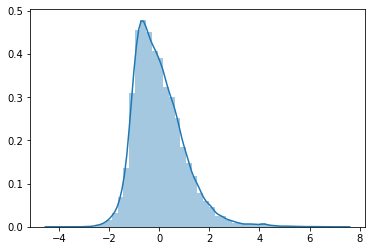

In [218]:
bldg_res = df_bldg.join(df_sale, how = 'left')




lookup_dict = {}
for col in bldg_res.columns:
    try:
        search_string = col[-3:]
        amount = int(bldg_res[bldg_res[col]== True]['saleprice'].mean())
        span = float(bldg_res[bldg_res[col]== True]['saleprice'].std())
        lookup_dict[col] = (amount, span)
    except:
        continue
        
lookup_dict

error_list = []       
for col in bldg_res.columns:
    try:
        df_filtered = bldg_res[bldg_res[col]== True]
        amount = df_filtered['saleprice'].mean()
        span = float(df_filtered['saleprice'].std())
        df_filtered['sigma_difference'] = (df_filtered['saleprice'] - amount)/span
        a = list(df_filtered['sigma_difference'])
        error_list.extend(a)

        
    except:
        continue   
error_list
info1 = list(filter(lambda x: np.abs(x)> 0, error_list))
sns.distplot(info1);

residues appear to be skewed slightly.

11 11 11 11


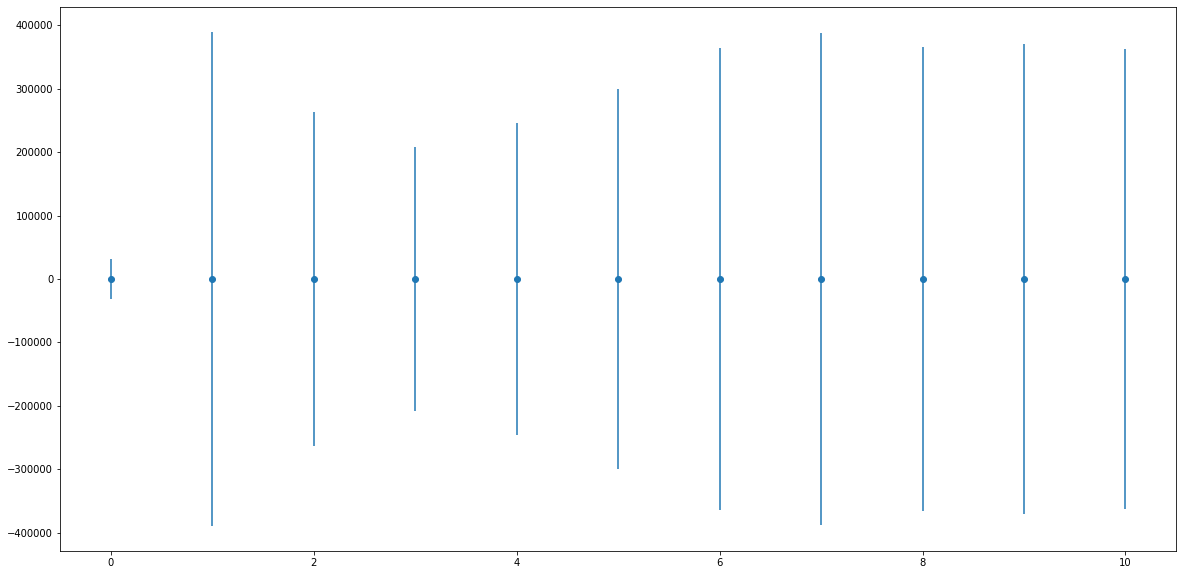

In [219]:
# remove nans from list in std from list
filtered_list = list(filter(lambda x: np.abs(x[1]) > 0, lookup_dict.values()))


fig = plt.figure(figsize = (20,10))
x = range(len(filtered_list))
y = [0]*len(x)
# y = [x[0] for x in lookup_dict.values()]
yerr = [num[1] for num in filtered_list]
print(len(filtered_list), len(x), len(y), len(yerr))
plt.errorbar(x, y, yerr=yerr, label='both limits (default)', fmt='o');

### Normalizing sqftliving by zipcode

In [220]:
df_test2 = zip_res.join(df_clean[['sqfttotliving']])

0.4289556707358094

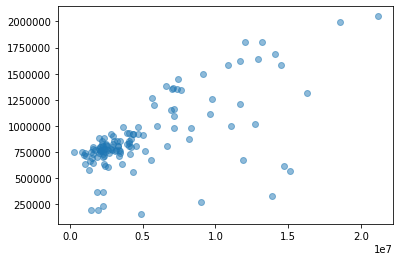

In [221]:
df_072 = df_test2[df_test2['zip_98007']==True][['saleprice','sqfttotliving']]




x = df_072[['sqfttotliving']]**2
y = df_072[['saleprice']]
plt.scatter(x, y, alpha=0.5)

model = LinearRegression()
model.fit(x, y)

a = model.score(x, y)

a

In [222]:
df_test2['livingzscore'] = 0
df_test2['salezscore'] = 0
# update_dictionary = {}

for col in df_test2.columns:
    try: 
        a = int(col[-3:])
        df_filtered = df_test2[df_test2[col]==True]
        index = list(df_filtered.index.values)
        ave1 = df_filtered['sqfttotliving'].mean()
        sig1 = df_filtered['sqfttotliving'].std()
        alist = list((df_filtered['sqfttotliving'] - ave1)/sig1)
        
        ave2 = df_filtered['saleprice'].mean()
        sig2 = df_filtered['saleprice'].std()
        blist = list((df_filtered['saleprice'] - ave2)/sig2)
        
        df_test2.loc[index, 'livingzscore'] = alist
        df_test2.loc[index, 'salezscore'] = blist
    except:
        continue
        

df_test2.dropna(inplace = True)

In [223]:
df_test2.salezscore.std()

0.9983055379536883

/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     677.5
Date:                Thu, 05 Dec 2019   Prob (F-statistic):               0.00
Time:                        17:56:25   Log-Likelihood:            -3.1737e+05
No. Observations:               23332   AIC:                         6.349e+05
Df Residuals:                   23253   BIC:                         6.355e+05
Df Model:                          78                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.263e+05   5.24e+04      2.408      0.016    2.35e+04    2.29e+05
zip_98001     -1.212e+05   5.31e+04     -2.284      0.022   -2.25e+05   -1.72e+04
zip_98002     -1.046e+05   5.33e+04     -1.963      0.050   -2.09e+05    -154.511
zip_98003     -9.472e+04   5.32e+04     -1.780      0.075   -1.99e+05    9590.542
zip_98004       7.97e+05   5.51e+04     14.452      0.000    6.89e+05    9.05e+05
zip_98005      5.687e+05    5.5e+04     10.337      0.000    4.61e+05    6.77e+05
zip_98006      4.493e+05   5.31e+04      8.456      0.000    3.45e+05    5.53e+05
zip_98007      3.577e+05   5.52e+04      6.477      0.000    2.49e+05    4.66e+05
zip_98008      3.529e+05   5.35e+04      6.594      0.000    2.48e+05    4.58e+05
zip_98009      8.761e-07   4.19e-07      2.090      0.037    5.46e-08     1.7e-06
zip_98010      2700.0596   5.56e+04      0.049      0.961   -1.06e+05    1.12e+05
zip_98011      1.492e+05   5.41e+04      2.757      0.006    4.31e+04    2.55e+05
zip_98014      1.081e+05    5.5e+04      1.966      0.049     325.025    2.16e+05
zip_98019      7.488e+04   5.42e+04      1.382      0.167   -3.13e+04    1.81e+05
zip_98022     -6.133e+04   5.33e+04     -1.151      0.250   -1.66e+05    4.31e+04
zip_98023      -1.16e+05   5.29e+04     -2.195      0.028    -2.2e+05   -1.24e+04
zip_98024      1.717e+05   5.67e+04      3.025      0.002    6.04e+04    2.83e+05
zip_98027      2.404e+05   5.35e+04      4.498      0.000    1.36e+05    3.45e+05
zip_98028      1.258e+05   5.37e+04      2.342      0.019    2.05e+04    2.31e+05
zip_98029       3.16e+05   5.39e+04      5.867      0.000     2.1e+05    4.22e+05
zip_98030     -8.457e+04   5.35e+04     -1.580      0.114   -1.89e+05    2.04e+04
zip_98031     -7.813e+04   5.33e+04     -1.465      0.143   -1.83e+05    2.64e+04
zip_98032     -9.445e+04    5.4e+04     -1.750      0.080      -2e+05    1.13e+04
zip_98033      5.835e+05   5.33e+04     10.957      0.000    4.79e+05    6.88e+05
zip_98034       2.45e+05    5.3e+04      4.623      0.000    1.41e+05    3.49e+05
zip_98038     -2.716e+04   5.29e+04     -0.514      0.608   -1.31e+05    7.65e+04
zip_98039      1.028e+06   7.28e+04     14.118      0.000    8.85e+05    1.17e+06
zip_98040      7.188e+05    5.4e+04     13.306      0.000    6.13e+05    8.25e+05
zip_98042     -7.695e+04   5.28e+04     -1.457      0.145    -1.8e+05    2.66e+04
zip_98045      1.318e+05   5.33e+04      2.471      0.013    2.72e+04    2.36e+05
zip_98047     -1.139e+05   5.84e+04     -1.950      0.051   -2.28e+05     594.133
zip_98050      1.792e+05   9.07e+04      1.976      0.048    1452.629    3.57e+05
zip_98051     -1.641e+04   6.06e+04     -0.271      0.787   -1.35e+05    1.02e+05
zip_98052      3.691e+05   5.31e+04      6.949      0.000    2.65e+05    4.73e+05
zip_98053      3.191e+05   5.35e+04      5.959   

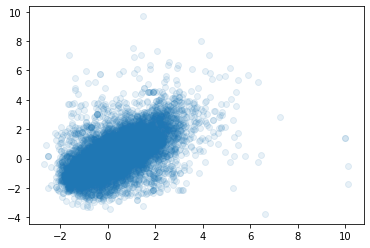

In [224]:
df_new = df_test2[['salezscore','livingzscore']]


y = np.array(df_test2['salezscore'])



x = np.array(df_test2['livingzscore'])


plt.scatter(x, y, alpha = .1)

df_test3 = df_test2.copy()

x_4 = df_test3.drop(['saleprice', 'salezscore','livingzscore', 'zip_98422', 'zip_98354',], axis = 1)

X_int = sm.add_constant(x_4)
avmodel4 = sm.OLS(df_test3[['saleprice']], X_int).fit()
avmodel4.summary()

In [225]:
# import numpy.linalg as LA

# condNO = 10**18
# new_r = .95
# r_squared = .94
# r_values = []

# df_test3 = df_test2.copy()

# list_to_drop = ['saleprice','salezscore','sqfttotliving', 'zip_98422', 'zip_98354']
# a = set(list_to_drop)

# while  new_r > r_squared and len(a) == len(list_to_drop):
#     print(new_r)
#     for col in df_test3.columns:
#         try:
#             int(col[-3:])
#             filter_list = [col]
#             filter_list.extend(list_to_drop)
#             df_x = df_test3.drop(filter_list, axis = 1)
#             df_y = df_test3[['saleprice']]
#             model = LinearRegression()
#             model.fit(df_x, df_y)
#             a = model.score(df_x, df_y)
#             b = LA.cond(df_x)
#             if b < condNO and a > r_squared:
#                 file_to_delete = col
#                 condNO = b
#                 new_r = a
#         except:
#             continue
#     list_to_drop.append(file_to_delete)
#     print(file_to_delete, condNO, new_r)
#     a = set(list_to_drop)



# # model = LinearRegression()
# # model.fit(df_x, df_y)

# # a = model.score(df_x, df_y)
# # b = LA.cond(df_x)

# # def reduce_conditional_number(df, r_limit):
# #     y_matrix = df[['saleprice']]
# #     for col in df.columns:
# #         x_matrix = df.drop(['saleprice', col], axis = 1)

# # reduce_conditional_number(df_x, .95)

# # LA.cond()

# # r2_score()


In [226]:
try:
    del df_test2['zip_98422']
    del df_test2['zip_98354']
except:
    print('already deleted')

x_4 = df_test2.drop(['saleprice', 'livingzscore', 'salezscore'], axis = 1)

X_int = sm.add_constant(x_4)
avmodel4 = sm.OLS(df_test2[['saleprice']], X_int).fit()
avmodel4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     677.5
Date:                Thu, 05 Dec 2019   Prob (F-statistic):               0.00
Time:                        17:56:34   Log-Likelihood:            -3.1737e+05
No. Observations:               23332   AIC:                         6.349e+05
Df Residuals:                   23253   BIC:                         6.355e+05
Df Model:                          78                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.263e+05   5.24e+04      2.408      0.016    2.35e+04    2.29e+05
zip_98001     -1.212e+05   5.31e+04     -2.284      0.022   -2.25e+05   -1.72e+04
zip_98002     -1.046e+05   5.33e+04     -1.963      0.050   -2.09e+05    -154.511
zip_98003     -9.472e+04   5.32e+04     -1.780      0.075   -1.99e+05    9590.542
zip_98004       7.97e+05   5.51e+04     14.452      0.000    6.89e+05    9.05e+05
zip_98005      5.687e+05    5.5e+04     10.337      0.000    4.61e+05    6.77e+05
zip_98006      4.493e+05   5.31e+04      8.456      0.000    3.45e+05    5.53e+05
zip_98007      3.577e+05   5.52e+04      6.477      0.000    2.49e+05    4.66e+05
zip_98008      3.529e+05   5.35e+04      6.594      0.000    2.48e+05    4.58e+05
zip_98009      8.761e-07   4.19e-07      2.090      0.037    5.46e-08     1.7e-06
zip_98010      2700.0596   5.56e+04      0.049      0.961   -1.06e+05    1.12e+05
zip_98011      1.492e+05   5.41e+04      2.757      0.006    4.31e+04    2.55e+05
zip_98014      1.081e+05    5.5e+04      1.966      0.049     325.025    2.16e+05
zip_98019      7.488e+04   5.42e+04      1.382      0.167   -3.13e+04    1.81e+05
zip_98022     -6.133e+04   5.33e+04     -1.151      0.250   -1.66e+05    4.31e+04
zip_98023      -1.16e+05   5.29e+04     -2.195      0.028    -2.2e+05   -1.24e+04
zip_98024      1.717e+05   5.67e+04      3.025      0.002    6.04e+04    2.83e+05
zip_98027      2.404e+05   5.35e+04      4.498      0.000    1.36e+05    3.45e+05
zip_98028      1.258e+05   5.37e+04      2.342      0.019    2.05e+04    2.31e+05
zip_98029       3.16e+05   5.39e+04      5.867      0.000     2.1e+05    4.22e+05
zip_98030     -8.457e+04   5.35e+04     -1.580      0.114   -1.89e+05    2.04e+04
zip_98031     -7.813e+04   5.33e+04     -1.465      0.143   -1.83e+05    2.64e+04
zip_98032     -9.445e+04    5.4e+04     -1.750      0.080      -2e+05    1.13e+04
zip_98033      5.835e+05   5.33e+04     10.957      0.000    4.79e+05    6.88e+05
zip_98034       2.45e+05    5.3e+04      4.623      0.000    1.41e+05    3.49e+05
zip_98038     -2.716e+04   5.29e+04     -0.514      0.608   -1.31e+05    7.65e+04
zip_98039      1.028e+06   7.28e+04     14.118      0.000    8.85e+05    1.17e+06
zip_98040      7.188e+05    5.4e+04     13.306      0.000    6.13e+05    8.25e+05
zip_98042     -7.695e+04   5.28e+04     -1.457      0.145    -1.8e+05    2.66e+04
zip_98045      1.318e+05   5.33e+04      2.471      0.013    2.72e+04    2.36e+05
zip_98047     -1.139e+05   5.84e+04     -1.950      0.051   -2.28e+05     594.133
zip_98050      1.792e+05   9.07e+04      1.976      0.048    1452.629    3.57e+05
zip_98051     -1.641e+04   6.06e+04     -0.271      0.787   -1.35e+05    1.02e+05
zip_98052      3.691e+05   5.31e+04      6.949      0.000    2.65e+05    4.73e+05
zip_98053      3.191e+05   5.35e+04      5.959   

In [227]:
x_4 = df_test2.drop(['saleprice', 'salezscore','sqfttotliving'], axis = 1)

X_int = sm.add_constant(x_4)
avmodel4 = sm.OLS(df_test2[['salezscore']], X_int).fit()
avmodel4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             salezscore   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     200.9
Date:                Thu, 05 Dec 2019   Prob (F-statistic):               0.00
Time:                        17:56:37   Log-Likelihood:                -27056.
No. Observations:               23332   AIC:                         5.427e+04
Df Residuals:                   23253   BIC:                         5.491e+04
Df Model:                          78                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.179e-13      0.207   5.71e-13      1.000      -0.405       0.405
zip_98001     -1.18e-13      0.209  -5.63e-13      1.000      -0.410       0.410
zip_98002    -1.174e-13      0.210  -5.58e-13      1.000      -0.412       0.412
zip_98003    -1.179e-13      0.210  -5.62e-13      1.000      -0.412       0.412
zip_98004    -1.176e-13      0.218  -5.41e-13      1.000      -0.426       0.426
zip_98005     -1.18e-13      0.217  -5.44e-13      1.000      -0.425       0.425
zip_98006     -1.18e-13      0.210  -5.63e-13      1.000      -0.411       0.411
zip_98007    -1.176e-13      0.218   -5.4e-13      1.000      -0.427       0.427
zip_98008     -1.18e-13      0.211  -5.59e-13      1.000      -0.414       0.414
zip_98009     2.818e-16   2.13e-14      0.013      0.989   -4.14e-14    4.19e-14
zip_98010    -1.189e-13      0.219  -5.42e-13      1.000      -0.430       0.430
zip_98011    -1.173e-13      0.214  -5.49e-13      1.000      -0.419       0.419
zip_98014    -1.173e-13      0.217  -5.41e-13      1.000      -0.425       0.425
zip_98019    -1.184e-13      0.214  -5.54e-13      1.000      -0.419       0.419
zip_98022     -1.17e-13      0.210  -5.56e-13      1.000      -0.412       0.412
zip_98023    -1.181e-13      0.209  -5.66e-13      1.000      -0.409       0.409
zip_98024    -1.175e-13      0.224  -5.25e-13      1.000      -0.439       0.439
zip_98027    -1.182e-13      0.211   -5.6e-13      1.000      -0.413       0.413
zip_98028    -1.178e-13      0.212  -5.56e-13      1.000      -0.415       0.415
zip_98029    -1.179e-13      0.212  -5.55e-13      1.000      -0.416       0.416
zip_98030    -1.179e-13      0.211  -5.58e-13      1.000      -0.414       0.414
zip_98031    -1.178e-13      0.210   -5.6e-13      1.000      -0.413       0.413
zip_98032    -1.171e-13      0.213   -5.5e-13      1.000      -0.417       0.417
zip_98033    -1.178e-13      0.210  -5.61e-13      1.000      -0.412       0.412
zip_98034    -1.177e-13      0.209  -5.63e-13      1.000      -0.410       0.410
zip_98038    -1.181e-13      0.209  -5.66e-13      1.000      -0.409       0.409
zip_98039    -1.167e-13      0.287  -4.06e-13      1.000      -0.563       0.563
zip_98040    -1.177e-13      0.213  -5.52e-13      1.000      -0.418       0.418
zip_98042    -1.172e-13      0.208  -5.63e-13      1.000      -0.408       0.408
zip_98045    -1.175e-13      0.210  -5.58e-13      1.000      -0.412       0.412
zip_98047    -1.186e-13      0.231  -5.14e-13      1.000      -0.452       0.452
zip_98050    -1.156e-13      0.358  -3.23e-13      1.000      -0.701       0.701
zip_98051    -1.173e-13      0.239   -4.9e-13      1.000      -0.469       0.469
zip_98052     -1.18e-13      0.210  -5.63e-13      1.000      -0.411       0.411
zip_98053     -1.18e-13      0.211  -5.59e-13      1.000      -0.414       0.414
zip_9

In [228]:
x0 = df_test2['livingzscore']
y0 = df_test2['salezscore']


x1 = df_test2['sqfttotliving']
y1 = df_test2['saleprice']

sigma_living = df_test2['sqfttotliving'].std()
sigma_cost = df_test2['saleprice'].std()

(0, 3537258.2375090504)

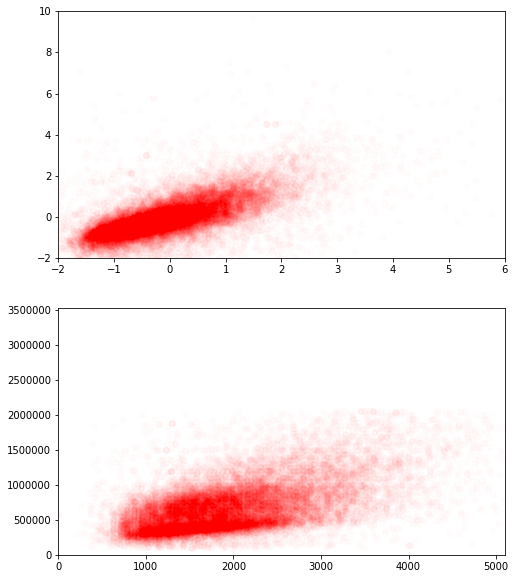

In [229]:
fig, ax = plt.subplots(2, figsize=(8,10))

ax0 = ax[0]
ax0.plot(x0, y0, 'ro', alpha = .01)
ax0.set_xlim([-2, 6])
ax0.set_ylim([-2, 10])


ax1 = ax[1]
ax1.plot(x1, y1, 'ro', alpha = .01)
ax1.set_xlim([0, 6* sigma_living])
ax1.set_ylim([0, 10* sigma_cost])
# plt.scatter(x, y, alpha = .002)

In [230]:
# Lucas' house 98072 2110sqft

In [231]:
def create_lookup_dict(df):
    lookup_dictzip = {}
    for col in df.columns:
        try:
            index = int(col[-3:])
            search_string = col[-3:]
            amount = int(df[df[col]== True]['sqfttotliving'].mean())
            span = float(df[df[col]== True]['sqfttotliving'].std())
            if span > 0:
                lookup_dictzip[col] = (amount, span)
        except:
            continue
    return lookup_dictzip

In [352]:
def get_value_from_list(zipcode, adict, df):
    
    #creates filter list
    filter_list = list(adict.keys())
    filter_list.append('saleprice')
    no_zip_list = filter_list.copy()
    value_list = list(adict.values())
    
    
    #adds zipcode to filter_list or removes it from no_zip_list depending if it was included in adict or not
    if 'zipcode' not in filter_list:
        filter_list.append('zipcode')
    else: 
        no_zip_list.remove('zipcode')
    
    
    
    filtered_df = df[filter_list]
    filtered_df['zipcode'] = pd.Categorical(filtered_df['zipcode'])
    df_onehotzip = pd.get_dummies(df['zipcode'], prefix = 'zip')
    
    for col in df_onehotzip.columns:
        if '98' not in col or df_onehotzip[col].sum() < 2:
            del df_onehotzip[col]
        
        
    
    
    df_z = df_onehotzip.join(filtered_df[no_zip_list], how = "left")
    df_z.columns = df_z.columns.str.replace(' ', '')

    
    #create filtered_dict
    filtered_dict = create_lookup_dict(df_z)
    
    df_z['livingzscore'] = 0
    df_z['salezscore'] = 0
    

    
    
    #normalizes
    for col in df_z.columns:
        try:
            a = int(col[-3:])
            df_filtered = df_z[df_z[col]==True]
            index = list(df_filtered.index.values)
            ave1 = df_filtered['sqfttotliving'].mean()
            sum1 = df_filtered['sqfttotliving'].sum()
            sig1 = df_filtered['sqfttotliving'].std()
            alist = list((df_filtered['sqfttotliving'] - ave1)/sig1)

            ave2 = df_filtered['saleprice'].mean()
            sig2 = df_filtered['saleprice'].std()
            blist = list((df_filtered['saleprice'] - ave2)/sig2)

            df_z.loc[index, 'livingzscore'] = alist
            df_z.loc[index, 'salezscore'] = blist
        except:
            continue
    df_z.dropna(inplace = True)

    #calculates the params
    drop_list = ['sqfttotliving','saleprice','salezscore','zip_98000']
    x = df_z.drop(drop_list, axis = 1)

    X_int = sm.add_constant(x)
    model = sm.OLS(df_z[['saleprice']], X_int).fit()
    return model.summary()
    parameters = dict(model.params)
    errors = dict(model.bse)
    
    zip_index = f'zip_{zipcode}'
    
    final_list = list(adict.keys())
    cost = parameters[zip_index] + parameters['livingzscore']*(adict['sqfttotliving']-filtered_dict[zip_index][0])/filtered_dict[zip_index][1]
    return cost
    
    try:
        final_list.remove('sqfttotliving')
    except:
        print('the function requires a "sqfttotliving arguement')
        return
#     for item in final_list:
#         try:
#             cost += parameters[item]*
#         except:
#             continue
    
    
    zip_coe = int(df_parameters.loc[zip_indx])
    cons = int(df_parameters.loc['const'])
    liv = int(df_parameters.loc['livingzscore'])
    
    zip_err = int(df_errors.loc[zip_indx])
    cons_err = int(df_errors.loc['const'])
    liv_err = int(df_errors.loc['livingzscore'])

    estimated_price= zip_coe + cons + liv*(sqft-filtered_dict[zip_indx][0])/filtered_dict[zip_indx][1]
    error = np.sqrt(zip_err**2 + cons_err**2+(liv_err*(sqft-filtered_dict[zip_indx][0])/filtered_dict[zip_indx][1])**2)

    return estimated_price, error

In [353]:
search_dict = {'sqfttotliving': 2110, 'sqftlot':32670}
get_value_from_list(98072, search_dict, df_clean)

/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     471.9
Date:                Thu, 05 Dec 2019   Prob (F-statistic):               0.00
Time:                        18:51:27   Log-Likelihood:            -3.9234e+05
No. Observations:               28433   AIC:                         7.848e+05
Df Residuals:                   28352   BIC:                         7.855e+05
Df Model:                          80                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         8.515e+05   3350.181    254.173      0.000    8.45e+05    8.58e+05
zip_98001     -4.75e+05   1.11e+04    -42.927      0.000   -4.97e+05   -4.53e+05
zip_98002    -5.437e+05   1.26e+04    -43.074      0.000   -5.68e+05   -5.19e+05
zip_98003    -4.642e+05   1.21e+04    -38.208      0.000   -4.88e+05    -4.4e+05
zip_98004       5.5e+05   2.13e+04     25.797      0.000    5.08e+05    5.92e+05
zip_98005     3.658e+05   2.08e+04     17.606      0.000    3.25e+05    4.06e+05
zip_98006     2.306e+05   1.14e+04     20.160      0.000    2.08e+05    2.53e+05
zip_98007     3.288e+04   2.17e+04      1.518      0.129   -9562.185    7.53e+04
zip_98008     3.465e+04    1.4e+04      2.475      0.013    7210.535    6.21e+04
zip_98010     -3.63e+05    2.3e+04    -15.804      0.000   -4.08e+05   -3.18e+05
zip_98011    -1.659e+05    1.7e+04     -9.750      0.000   -1.99e+05   -1.33e+05
zip_98014    -2.124e+05   2.09e+04    -10.140      0.000   -2.53e+05   -1.71e+05
zip_98019     -2.61e+05   1.74e+04    -15.027      0.000   -2.95e+05   -2.27e+05
zip_98022    -4.845e+05   1.28e+04    -37.807      0.000    -5.1e+05   -4.59e+05
zip_98023    -4.558e+05   9531.250    -47.825      0.000   -4.75e+05   -4.37e+05
zip_98024    -1.742e+05   2.72e+04     -6.407      0.000   -2.27e+05   -1.21e+05
zip_98027    -8701.5201   1.36e+04     -0.641      0.522   -3.53e+04    1.79e+04
zip_98028    -1.974e+05    1.5e+04    -13.173      0.000   -2.27e+05   -1.68e+05
zip_98029     5.441e+04   1.57e+04      3.465      0.001    2.36e+04    8.52e+04
zip_98030    -4.584e+05    1.4e+04    -32.692      0.000   -4.86e+05   -4.31e+05
zip_98031     -4.28e+05   1.29e+04    -33.238      0.000   -4.53e+05   -4.03e+05
zip_98032    -4.913e+05   1.63e+04    -30.210      0.000   -5.23e+05   -4.59e+05
zip_98033     2.964e+05   1.23e+04     24.068      0.000    2.72e+05     3.2e+05
zip_98034    -8.904e+04   1.06e+04     -8.435      0.000    -1.1e+05   -6.83e+04
zip_98038    -3.346e+05   9741.512    -34.347      0.000   -3.54e+05   -3.15e+05
zip_98039     6.832e+05   6.16e+04     11.090      0.000    5.62e+05    8.04e+05
zip_98040     5.213e+05   1.65e+04     31.637      0.000    4.89e+05    5.54e+05
zip_98042    -4.321e+05   9079.538    -47.587      0.000    -4.5e+05   -4.14e+05
zip_98045     -2.08e+05   1.28e+04    -16.205      0.000   -2.33e+05   -1.83e+05
zip_98047     -5.61e+05   3.17e+04    -17.678      0.000   -6.23e+05   -4.99e+05
zip_98050    -1.183e+05   9.02e+04     -1.312      0.190   -2.95e+05    5.84e+04
zip_98051    -3.387e+05   3.75e+04     -9.039      0.000   -4.12e+05   -2.65e+05
zip_98052     6.658e+04   1.14e+04      5.853      0.000    4.43e+04    8.89e+04
zip_98053      6.11e+04    1.4e+04      4.358      0.000    3.36e+04    8.86e+04
zip_98055     -4.19e+05   1.41e+04    -29.650      0.000   -4.47e+05   -3.91e+05
zip_9

In [354]:
def get_value(zipcode, sqft, df):
    
    #creates zipcode dummies
    filtered_df = df[['saleprice','zipcode','sqfttotliving']]
    filtered_df['zipcode'] = pd.Categorical(filtered_df['zipcode'])
    df_onehotzip = pd.get_dummies(df_zip['zipcode'], prefix = 'zip')
    df_z = df_onehotzip.join(filtered_df[['saleprice','sqfttotliving']], how = "left")

    
    #create filtered_dict
    filtered_dict = create_lookup_dict(df_z)
    
    df_z['livingzscore'] = 0
    df_z['salezscore'] = 0
    
    
    #normalizes
    for col in df_z.columns:
        try: 
            a = int(col[-3:])
            df_filtered = df_z[df_z[col]==True]
            index = list(df_filtered.index.values)
            ave1 = df_filtered['sqfttotliving'].mean()
            sig1 = df_filtered['sqfttotliving'].std()
            alist = list((df_filtered['sqfttotliving'] - ave1)/sig1)

            ave2 = df_filtered['saleprice'].mean()
            sig2 = df_filtered['saleprice'].std()
            blist = list((df_filtered['saleprice'] - ave2)/sig2)

            df_z.loc[index, 'livingzscore'] = alist
            df_z.loc[index, 'salezscore'] = blist
        except:
            continue
    df_z.dropna(inplace = True)        

    #calculates the params
    x = df_z.drop(['saleprice', 'salezscore','sqfttotliving', 'zip_98422', 'zip_98354','zip_98000'], axis = 1)

    X_int = sm.add_constant(x)
    model = sm.OLS(df_z[['saleprice']], X_int).fit()
    df_parameters = pd.DataFrame(model.params)
    df_errors = pd.DataFrame(model.bse)

    
    zip_indx = f'zip_{zipcode}'
    
    zip_coe = int(df_parameters.loc[zip_indx])
    cons = int(df_parameters.loc['const'])
    liv = int(df_parameters.loc['livingzscore'])
    
    zip_err = int(df_errors.loc[zip_indx])
    cons_err = int(df_errors.loc['const'])
    liv_err = int(df_errors.loc['livingzscore'])

    estimated_price= zip_coe + cons + liv*(sqft-filtered_dict[zip_indx][0])/filtered_dict[zip_indx][1]
    error = np.sqrt(zip_err**2 + cons_err**2+(liv_err*(sqft-filtered_dict[zip_indx][0])/filtered_dict[zip_indx][1])**2)

    return estimated_price, error
    
    
    

In [355]:
a = get_value(98103, 2460 , df_clean)
a

/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


(1079300.6714905677, 75437.72242916698)

{'zip_98000': (1245273, 6684.98750933762),
 'zip_98001': (382299, 115902.34662302973),
 'zip_98002': (309339, 84077.62286627582),
 'zip_98003': (391080, 143091.10908321402),
 'zip_98004': (1335368, 487749.69128576695),
 'zip_98005': (1226165, 313967.2387728881),
 'zip_98006': (1085702, 368065.0954631843),
 'zip_98007': (882941, 351779.3605545098),
 'zip_98008': (879868, 292544.39955027954),
 'zip_98010': (499921, 284791.08172019944),
 'zip_98011': (684970, 178985.78592112724),
 'zip_98014': (688436, 307941.8108321855),
 'zip_98019': (620064, 212646.11570540667),
 'zip_98022': (402769, 174682.81873662543),
 'zip_98023': (399705, 138174.5266356886),
 'zip_98024': (760765, 364200.99789579946),
 'zip_98027': (866073, 289576.42607644945),
 'zip_98028': (654933, 199390.32220512407),
 'zip_98029': (911648, 216325.59144949637),
 'zip_98030': (398280, 116241.41197454897),
 'zip_98031': (427534, 139782.21515868124),
 'zip_98032': (362110, 105391.89197723154),
 'zip_98033': (1147788, 405453.76624